CẬP NHẬT THƯ VIỆN

In [ ]:
# Cài đặt thư viện cần thiết
!pip install transformers datasets torch accelerate evaluate underthesea

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 65.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.4/978.4 kB 51.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 57.1 MB/s eta 0:00:00


IMPORT & KHỞI TẠO

In [ ]:
import torch
from datasets import Dataset, DatasetDict, load_dataset, concatenate_datasets
from transformers import (
    AutoTokenizer, AutoModelForSeq2SeqLM,
    Seq2SeqTrainer, Seq2SeqTrainingArguments,
    DataCollatorForSeq2Seq
)
from underthesea import text_normalize
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import random
import os

from google.colab import drive
drive.mount('/content/drive')

# Tạo đường dẫn gốc để lưu cho gọn (Bạn có thể đổi tên thư mục 'NLP_Project' tùy ý)
drive_path = "/content/drive/MyDrive/NLP_Project"
import os
os.makedirs(drive_path, exist_ok=True)

Mounted at /content/drive


LLM

In [ ]:
!pip install -q google-generativeai

import google.generativeai as genai
from google.colab import userdata
import pandas as pd # Đảm bảo pandas đã được import

# --- Cấu hình API Key ---
# (Đảm bảo bạn đã làm theo hướng dẫn 4 bước ở trên)
try:
    GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')
    genai.configure(api_key=GOOGLE_API_KEY)
    print("Đã cấu hình Google AI API key thành công!")
except Exception as e:
    print("LỖI: Không tìm thấy GOOGLE_API_KEY. Vui lòng làm theo hướng dẫn (vào mục 'Secrets' 🔑) để thêm API key.")

Đã cấu hình Google AI API key thành công!


TẢI & XỬ LÝ DỮ LIỆU GỐC

In [ ]:
# Tải dataset (sẽ tự động tải cả 3 split: train, validation, test)
dataset_all_splits = load_dataset("clapAI/VLSP2016_SA")
print("--- Tải dữ liệu gốc thành công ---")
print(dataset_all_splits)

# Làm sạch
def clean(example):
    # text_normalize từ underthesea để chuẩn hóa unicode, dấu câu
    text = text_normalize(example['text'].strip())
    # Lọc bỏ các câu quá ngắn (dưới 3 từ)
    if len(text.split()) < 3:
        return None
    # Chỉ giữ lại text và label, các cột khác không cần thiết
    return {"text": text, "label": example['label']}

# Áp dụng .map và .filter cho TẤT CẢ các split (train, validation, test)
# Bỏ các cột không dùng đến
cleaned_data = dataset_all_splits.map(clean)

# Filter (lọc) các mẫu None (bị return None do quá ngắn)
# (Lưu ý: Dataset gốc có một số mẫu label=None, cần lọc ra)
cleaned_data = cleaned_data.filter(lambda x: x['text'] is not None and x['label'] is not None)

print("\n--- Sau khi làm sạch và lọc ---")
print(cleaned_data)

# Gán lại vào biến `data` để các ô code sau (cell [5], [6]) tự động sử dụng
data = cleaned_data

print(f"\nSử dụng bộ dữ liệu chính thức:")
print(f"Train: {len(data['train'])} mẫu")
print(f"Validation: {len(data['validation'])} mẫu")
print(f"Test: {len(data['test'])} mẫu")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/61.0 [00:00<?, ?B/s]

train.csv: 0.00B [00:00, ?B/s]

val.csv: 0.00B [00:00, ?B/s]

test.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/4080 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1020 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1050 [00:00<?, ? examples/s]

--- Tải dữ liệu gốc thành công ---
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 4080
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1020
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1050
    })
})


Map:   0%|          | 0/4080 [00:00<?, ? examples/s]

Map:   0%|          | 0/1020 [00:00<?, ? examples/s]

Map:   0%|          | 0/1050 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4014 [00:00<?, ? examples/s]

Filter:   0%|          | 0/999 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1037 [00:00<?, ? examples/s]


--- Sau khi làm sạch và lọc ---
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 4014
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 999
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1037
    })
})

Sử dụng bộ dữ liệu chính thức:
Train: 4014 mẫu
Validation: 999 mẫu
Test: 1037 mẫu


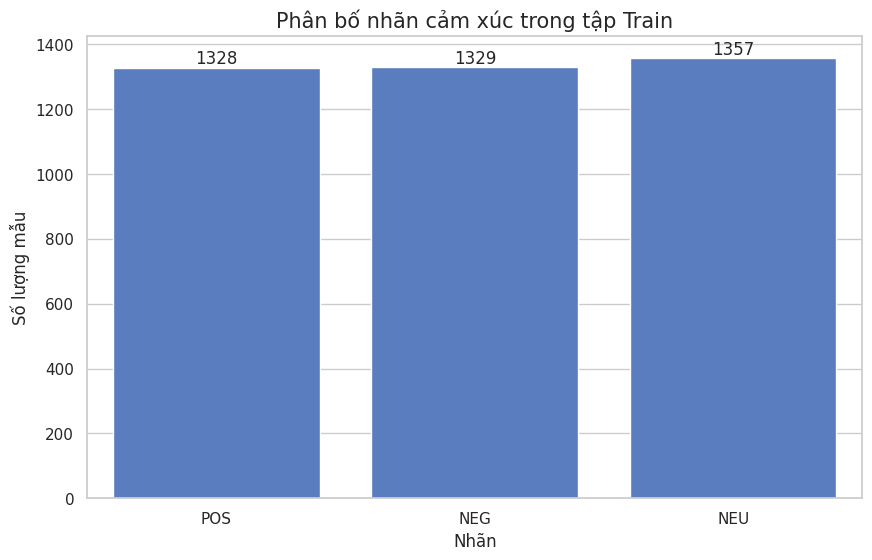

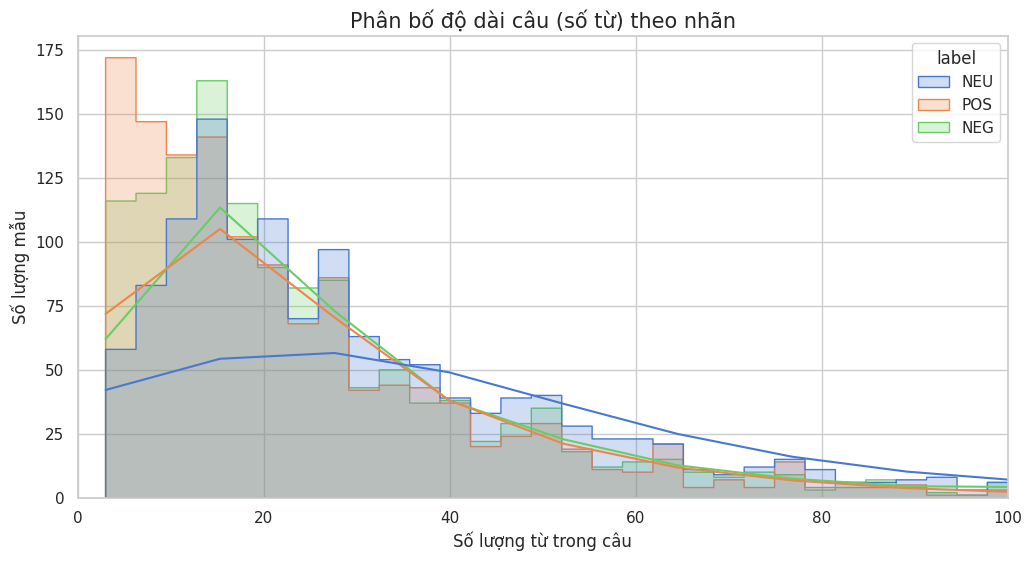

Độ dài trung bình: 32.78 từ
Câu dài nhất: 2452 từ
Câu ngắn nhất: 3 từ


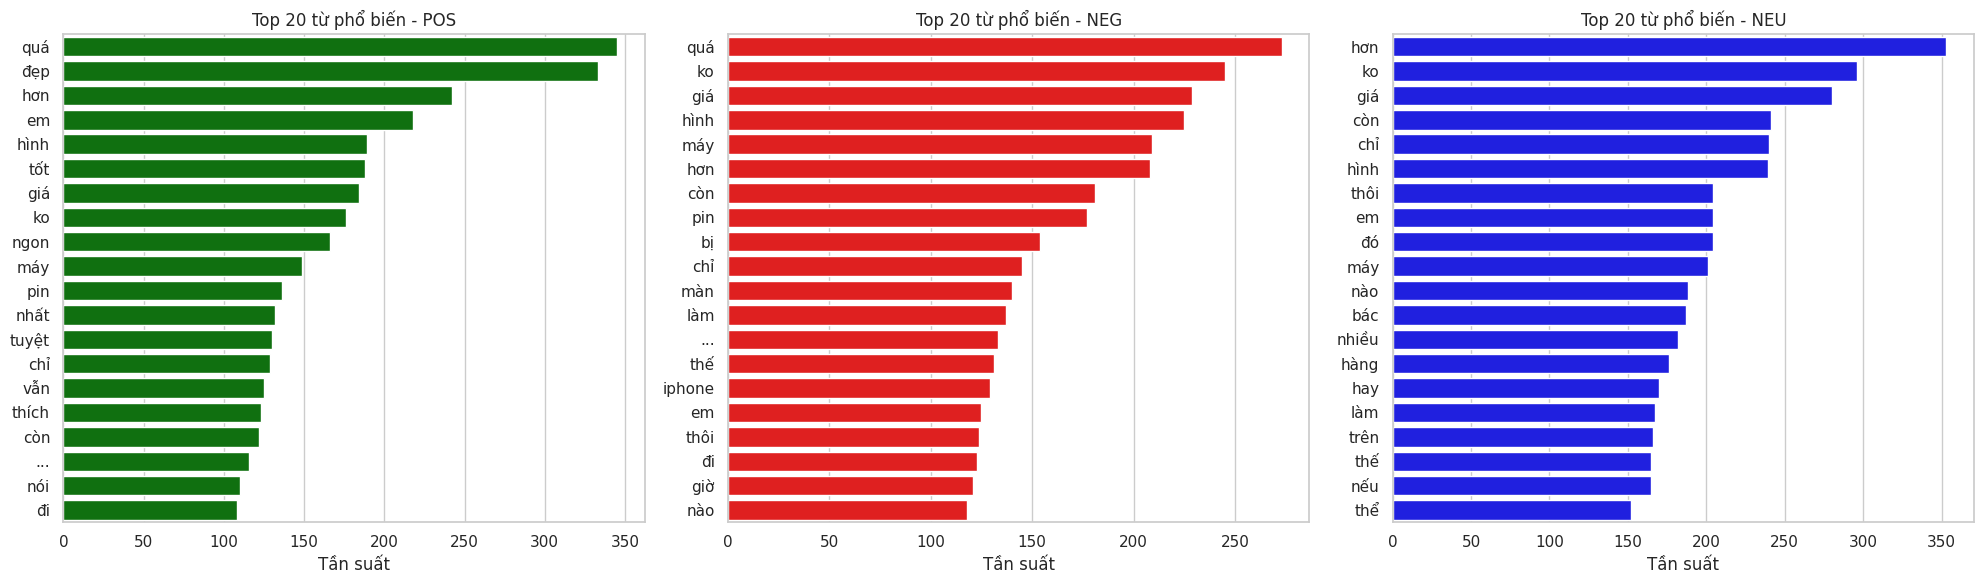


--- Word Cloud cho toàn bộ tập Train ---


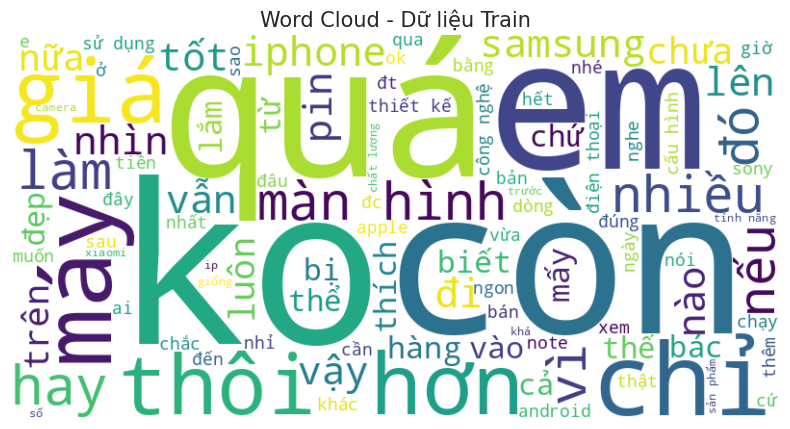


--- Word Cloud cho nhãn NEGATIVE (Những lời chê trách) ---


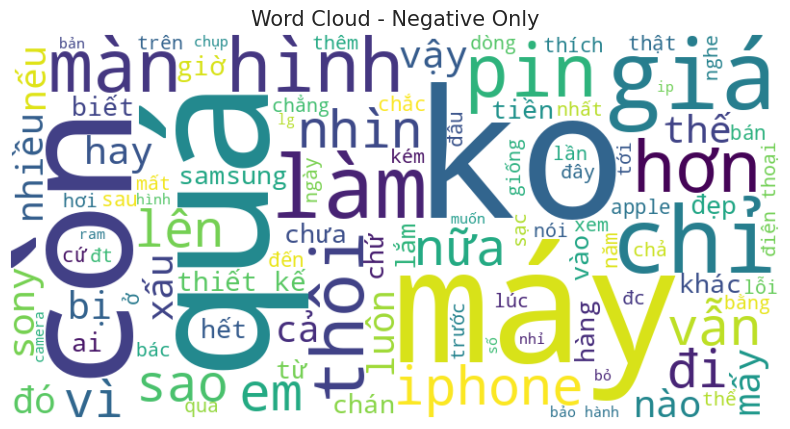

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter

# 1. Chuyển đổi dữ liệu Train sang Pandas DataFrame để dễ xử lý
df_train = data['train'].to_pandas()

# Cài đặt style cho biểu đồ
sns.set(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (12, 6)

# ---------------------------------------------------------
# PHẦN 1: PHÂN BỐ NHÃN (LABEL DISTRIBUTION)
# ---------------------------------------------------------
plt.figure(figsize=(10, 6))
plt.title("Phân bố nhãn cảm xúc trong tập Train", fontsize=15)
ax = sns.countplot(x='label', data=df_train, order=['POS', 'NEG', 'NEU'])
ax.bar_label(ax.containers[0])
plt.xlabel("Nhãn")
plt.ylabel("Số lượng mẫu")
plt.show()

# ---------------------------------------------------------
# PHẦN 2: PHÂN BỐ ĐỘ DÀI CÂU (SENTENCE LENGTH)
# ---------------------------------------------------------
# Tính số từ trong mỗi câu
df_train['word_count'] = df_train['text'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(12, 6))
sns.histplot(data=df_train, x='word_count', hue='label', kde=True, element="step")
plt.title("Phân bố độ dài câu (số từ) theo nhãn", fontsize=15)
plt.xlabel("Số lượng từ trong câu")
plt.ylabel("Số lượng mẫu")
plt.xlim(0, 100) # Giới hạn hiển thị câu dưới 100 từ để nhìn rõ hơn
plt.show()

print(f"Độ dài trung bình: {df_train['word_count'].mean():.2f} từ")
print(f"Câu dài nhất: {df_train['word_count'].max()} từ")
print(f"Câu ngắn nhất: {df_train['word_count'].min()} từ")

# ---------------------------------------------------------
# PHẦN 3: TỪ KHÓA PHỔ BIẾN & WORD CLOUD
# ---------------------------------------------------------

# Danh sách Stopwords tiếng Việt cơ bản (để loại bỏ những từ không mang nhiều ý nghĩa)
vietnamese_stopwords = set([
    "là", "của", "và", "có", "những", "các", "trong", "để", "với", "thì", "mà",
    "một", "nhưng", "khi", "này", "được", "cho", "đã", "sẽ", "về", "như",
    "cũng", "ra", "lại", "cái", "con", "người", "mình", "bạn", "tôi", "mới",
    "rất", "đang", "nên", "phải", "gì", "nó", "không", "thấy", "mua", "dùng", "xài", "rồi"
])

def get_common_words(text_series, top_n=20):
    all_words = " ".join(text_series).lower().split()
    # Lọc bỏ stopwords
    clean_words = [w for w in all_words if w not in vietnamese_stopwords and len(w) > 1]
    return Counter(clean_words).most_common(top_n)

# Vẽ biểu đồ Top từ khóa cho từng nhãn
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
labels = ['POS', 'NEG', 'NEU']
colors = ['green', 'red', 'blue']

for i, label in enumerate(labels):
    subset = df_train[df_train['label'] == label]
    common_words = get_common_words(subset['text'])

    words = [w[0] for w in common_words]
    counts = [w[1] for w in common_words]

    sns.barplot(x=counts, y=words, ax=axes[i], color=colors[i])
    axes[i].set_title(f"Top 20 từ phổ biến - {label}")
    axes[i].set_xlabel("Tần suất")

plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# PHẦN 4: WORD CLOUD (TRỰC QUAN HÓA DẠNG MÂY)
# ---------------------------------------------------------
def plot_wordcloud(text_series, title):
    text = " ".join(text_series).lower()
    # Loại bỏ stopwords thủ công khỏi chuỗi để wordcloud sạch hơn
    text = " ".join([word for word in text.split() if word not in vietnamese_stopwords])

    wc = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=15)
    plt.show()

print("\n--- Word Cloud cho toàn bộ tập Train ---")
plot_wordcloud(df_train['text'], "Word Cloud - Dữ liệu Train")

# Nếu muốn xem riêng cho Negative (để xem người dùng hay chê gì nhất)
print("\n--- Word Cloud cho nhãn NEGATIVE (Những lời chê trách) ---")
plot_wordcloud(df_train[df_train['label'] == 'NEG']['text'], "Word Cloud - Negative Only")

CHUẨN BỊ INPUT/OUTPUT + TOKENIZE

In [ ]:
model_name = "VietAI/vit5-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

prefix = "Phân loại cảm xúc: "
# This map is for output/target text for integer labels if they were integers. Not directly used for raw dataset labels.
label_map = {0: "neutral", 1: "positive", 2: "negative"}

# New mapping to convert original dataset labels (strings) to descriptive strings
original_label_to_descriptive_map = {
    "NEU": "neutral",
    "POS": "positive",
    "NEG": "negative"
}

def prepare(example):
    # Use the new map to convert the original string label to the descriptive string
    target_text = original_label_to_descriptive_map[example['label']]
    return {
        "input_text": prefix + example['text'],
        "target_text": target_text
    }

# ÁP DỤNG TRƯỚC KHI TOKENIZE
data = data.map(prepare, remove_columns=['text', 'label'])
print("Đã thêm input_text & target_text")

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/820k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

Map:   0%|          | 0/4014 [00:00<?, ? examples/s]

Map:   0%|          | 0/999 [00:00<?, ? examples/s]

Map:   0%|          | 0/1037 [00:00<?, ? examples/s]

Đã thêm input_text & target_text


In [ ]:
def tokenize(examples):
    model_inputs = tokenizer(
        examples['input_text'],
        max_length=128,
        truncation=True,
        padding=False
    )
    # Tokenize target (dùng context riêng)
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            examples['target_text'],
            max_length=8,
            truncation=True,
            padding=False
        )
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Tokenize
tokenized = data.map(tokenize, batched=True)

# XÓA CỘT GỐC SAU KHI DÙNG XONG
tokenized = tokenized.remove_columns(['input_text', 'target_text'])

print("Tokenize xong! Các cột:", tokenized["train"].column_names)

Map:   0%|          | 0/4014 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:4118: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/999 [00:00<?, ? examples/s]

Map:   0%|          | 0/1037 [00:00<?, ? examples/s]

Tokenize xong! Các cột: ['input_ids', 'attention_mask', 'labels']


TẠO SYNTHETIC DATA

In [ ]:
import google.generativeai as genai
from IPython.display import display, Markdown

# --- CẤU HÌNH API ---
try:
    model_gemini = genai.GenerativeModel('models/gemini-2.5-pro')
    print("Đã khởi tạo mô hình")
except Exception as e:
    print(f"Lỗi khởi tạo mô hình: {e}. Đảm bảo API key của bạn đã được cấu hình đúng.")
    # Dừng nếu không khởi tạo được
    raise e


# --- NỘI DUNG PROMPT ---
base_prompt = """
Nhiệm vụ: Đóng vai một tập hợp đa dạng gồm nhiều người dùng công nghệ tại Việt Nam, từ người dùng phổ thông đến người có hiểu biết chuyên sâu. Viết các bình luận mới và phải tuyệt đối đa dạng về trải nghiệm sử dụng sản phẩm, phần mềm và dịch vụ công nghệ.

Chủ đề bao phủ (Yêu cầu đa dạng):
1. Thiết bị phổ thông: Điện thoại (iPhone, Samsung, Xiaomi...), Laptop (Dell, HP, Asus, Macbook...), Đồng hồ (Apple Watch, Garmin...), Tai nghe (Sony, Airpods...).
2. Linh kiện PC: CPU (Intel, AMD), GPU (Nvidia), Mainboard, RAM, Nguồn (PSU), Vỏ case.
3. Dịch vụ & Phần mềm:
   - Ứng dụng (Zalo, Facebook, Grab, Shopee, MoMo...).
   - Dịch vụ (Giao hàng, CSKH, Bảo hành, Mạng FPT/Viettel...).
   - Streaming (Netflix, Spotify...).
   - Hệ điều hành & Phần mềm làm việc (Windows, Google Docs, Excel...).
4. Thiết bị ngách: Nhà thông minh (Đèn, Loa Google/Alexa), Gaming (PS5, Switch), VR/Drone.

Yêu cầu về Văn phong và Cảm xúc (Rất quan trọng):
- Tự nhiên: Văn phong phải giống hệt cách người Việt bình luận trên mạng xã hội (ví dụ: Tinhte, VOZ, các group Facebook). Câu văn phải tự nhiên, dài trên 5 chữ, và thể hiện rõ cảm xúc.
- Cảm xúc (Negative/Positive): Phải chứa các tính từ chỉ cảm xúc mạnh (ví dụ: bực mình, thất vọng, chán ghê, ức chế... hoặc rất hài lòng, tuyệt vời, ưng ý, mê ly...).
- Cảm xúc (Neutral): Không được là các câu mô tả thông số kỹ thuật khô khan. Nhãn neutral phải thể hiện cảm xúc của người dùng thật, ví dụ: phân vân, tò mò, hơi tiếc, ngạc nhiên, đang hóng, không chắc lắm...

Yêu cầu về Định dạng và Chất lượng (Bắt buộc):
- Số lượng: Sinh ra chính xác 50 mẫu bình luận khác nhau.
- Tuyệt đối đa dạng: Không lặp lại ý tưởng đã có. Mỗi bình luận phải là một khía cạnh, sản phẩm, hoặc trải nghiệm riêng biệt.
- Sạch 100%: Câu văn không được chứa bất kỳ dấu ngoặc đơn () hay dấu ngoặc kép "" nào để giải thích hay nhấn mạnh.
- Định dạng: Xuất dữ liệu theo định dạng nghiêm ngặt mỗi dòng một mẫu:
[Nội dung bình luận] | [nhãn]
(với nhãn là positive, negative, hoặc neutral).
"""

# --- THỰC THI ---
try:
    print("--- ĐANG SINH DỮ LIỆU (Vui lòng đợi vài giây)... ---")

    # Gọi API để sinh nội dung
    response = model_gemini.generate_content(
        base_prompt,
        generation_config=genai.types.GenerationConfig(
            temperature=0.9, # Tăng độ sáng tạo và đa dạng
            max_output_tokens=4000 # Đảm bảo đủ độ dài cho 50 câu
        )
    )

    # --- XỬ LÝ VÀ IN KẾT QUẢ ---
    if response.text:
        # Tách các dòng để xử lý (nếu cần) hoặc in trực tiếp
        lines = response.text.strip().split('\n')

        count = 0
        for line in lines:
            # Chỉ in những dòng có chứa ký tự phân cách '|' để đảm bảo đúng định dạng
            if "|" in line:
                print(line)
                count += 1

        print(f"\n--- ĐÃ SINH XONG: {count} mẫu ---")
    else:
        print("Không nhận được phản hồi từ model.")

except Exception as e:
    print(f"Có lỗi xảy ra: {e}")

Đã khởi tạo mô hình
--- ĐANG SINH DỮ LIỆU (Vui lòng đợi vài giây)... ---
Pin con iPhone 15 Pro Max trâu thật sự, xài cả ngày không phải nghĩ. | positive
Cái màn hình gập của Samsung Z Fold 5 dùng thích thật nhưng nếp gấp vẫn còn hơi lộ, nhìn nghiêng thấy rõ. | neutral
Điện thoại Xiaomi sạc nhanh kinh khủng, cắm tí đã đầy nhưng cái hệ điều hành MIUI nhiều quảng cáo bực mình quá. | negative
Macbook Air M2 làm việc văn phòng thì mượt thôi rồi, mở chục tab chrome cũng không xi nhê. | positive
Con Dell Inspiron của mình mới hết bảo hành đã lăn ra hỏng bản lề, chán không buồn nói. | negative
Đeo Apple Watch tiện ghê, xem thông báo không cần rút điện thoại, đo sức khoẻ cũng chuẩn. | positive
Đồng hồ Garmin pin cả tuần mới sạc, chuyên cho dân chạy bộ thì không có đối thủ. | positive
Airpods Pro 2 chống ồn đỉnh cao, đeo vào là không gian riêng luôn, rất đáng tiền. | positive
Tai nghe Sony WH-1000XM5 nghe nhạc thì tuyệt vời nhưng đeo lâu hơi nóng tai, mùa hè đúng là cực hình. | negative
Dựng con

In [ ]:
# Đọc file synthetic_raw.txt
with open(f"{drive_path}/encoder-decoder_synthetic_data.txt", "r", encoding="utf-8") as f:
    lines = [l.strip() for l in f.readlines() if "|" in l and l.strip()]

synthetic_list = []
for line in lines:
    parts = line.split("|", 1)
    if len(parts) != 2: continue
    text = parts[0].strip()
    label = parts[1].strip().lower()
    if label not in ["positive", "negative", "neutral"]: continue
    synthetic_list.append({
        "input_text": prefix + text,
        "target_text": label
    })

print(f"Đã tạo {len(synthetic_list)} mẫu synthetic hợp lệ")

synthetic_dataset = Dataset.from_list(synthetic_list)
tokenized_synthetic = synthetic_dataset.map(tokenize, batched=True, remove_columns=['input_text', 'target_text'])

Đã tạo 1500 mẫu synthetic hợp lệ


Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

GỘP SYNTHETIC VÀO TRAIN

In [ ]:
# Tokenize synthetic
tokenized_synthetic = synthetic_dataset.map(tokenize, batched=True)
tokenized_synthetic = tokenized_synthetic.remove_columns(['input_text', 'target_text'])

# Gộp vào train
augmented_train = concatenate_datasets([tokenized["train"], tokenized_synthetic.shuffle(seed=42)])
print(f"Train gốc: {len(tokenized['train'])}, Train + synthetic: {len(augmented_train)}")

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

Train gốc: 4014, Train + synthetic: 5514


Nhãn gốc: Counter({'neutral': 1357, 'negative': 1329, 'positive': 1328})
Nhãn synthetic: Counter({'neutral': 508, 'negative': 497, 'positive': 495})


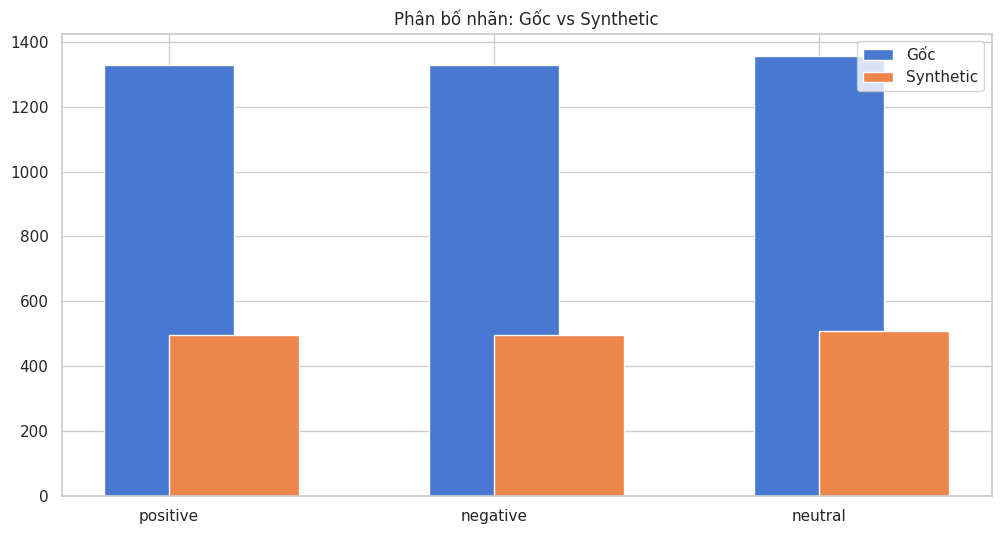

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

# Kiểm tra nhãn gốc
print("Nhãn gốc:", Counter(data['train']['target_text']))

# Kiểm tra synthetic
print("Nhãn synthetic:", Counter(synthetic_dataset['target_text']))

# Vẽ biểu đồ
labels = ['positive', 'negative', 'neutral']
orig_counts = [Counter(data['train']['target_text'])[l] for l in labels]
syn_counts = [Counter(synthetic_dataset['target_text'])[l] for l in labels]

x = range(len(labels))
plt.bar(x, orig_counts, width=0.4, label='Gốc', align='center')
plt.bar(x, syn_counts, width=0.4, label='Synthetic', align='edge')
plt.xticks(x, labels)
plt.legend()
plt.title("Phân bố nhãn: Gốc vs Synthetic")
plt.show()

METRICS

In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    pred_labels = [tokenizer.decode(p, skip_special_tokens=True).strip().lower() for p in predictions]
    true_labels = [tokenizer.decode(l, skip_special_tokens=True).strip().lower() for l in labels]
    # Xử lý nhãn rỗng
    true_labels = [l if l else 'neutral' for l in true_labels]
    return {
        "accuracy": accuracy_score(true_labels, pred_labels),
        "f1": f1_score(true_labels, pred_labels, average='macro')
    }

HUẤN LUYỆN LẦN 1 – BASELINE

In [ ]:
import os
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer, DataCollatorForSeq2Seq

# Định nghĩa đường dẫn lưu model trên Drive
baseline_save_path = f"{drive_path}/vit5_baseline_final"

print(f"Kiểm tra đường dẫn: {baseline_save_path}")

# --- KIỂM TRA XEM MODEL ĐÃ TỒN TẠI CHƯA ---
if os.path.exists(baseline_save_path):
    print("✅ ĐÃ TÌM THẤY mô hình Baseline trên Drive!")
    print("⏩ Bỏ qua quá trình huấn luyện để tiết kiệm thời gian.")
    print(f"Đường dẫn: {baseline_save_path}")

else:
    print("⚠️ CHƯA TÌM THẤY mô hình trên Drive. Bắt đầu huấn luyện mới...")

    # 1. Khởi tạo Model gốc
    model_baseline = AutoModelForSeq2SeqLM.from_pretrained(model_name)

    # 2. Thiết lập tham số
    args = Seq2SeqTrainingArguments(
        output_dir=f"{drive_path}/vit5_baseline_checkpoints",
        eval_strategy="epoch",
        learning_rate=5e-5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=16,
        weight_decay=0.01,
        save_total_limit=2,
        num_train_epochs=10,
        predict_with_generate=True,
        generation_max_length=8,
        generation_num_beams=1,
        fp16=True, # Tắt nếu không dùng GPU
        logging_steps=50,
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        report_to="none",
    )

    # 3. Khởi tạo Trainer
    trainer_baseline = Seq2SeqTrainer(
        model=model_baseline,
        args=args,
        train_dataset=tokenized["train"],
        eval_dataset=tokenized["validation"],
        processing_class=tokenizer,
        data_collator=DataCollatorForSeq2Seq(tokenizer, padding=True),
        compute_metrics=compute_metrics
    )

    # 4. Bắt đầu Train
    print("🚀 ĐANG HUẤN LUYỆN BASELINE...")
    trainer_baseline.train()

    # 5. Lưu Model cuối cùng vào đường dẫn chính
    trainer_baseline.save_model(baseline_save_path)
    print(f"💾 Đã lưu model Baseline thành công tại: {baseline_save_path}")

Kiểm tra đường dẫn: /content/drive/MyDrive/NLP_Project/vit5_baseline_final
⚠️ CHƯA TÌM THẤY mô hình trên Drive. Bắt đầu huấn luyện mới...


config.json:   0%|          | 0.00/702 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/904M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/904M [00:00<?, ?B/s]

🚀 ĐANG HUẤN LUYỆN BASELINE...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.278900,0.378095,0.622623,0.612385
2,0.161800,0.292550,0.701702,0.697564
3,0.101100,0.445457,0.701702,0.702945
4,0.049200,0.658552,0.720721,0.722978
5,0.023900,0.895864,0.729730,0.731435
6,0.007900,1.051592,0.725726,0.723207
7,0.014100,1.173875,0.730731,0.728885
8,0.007900,1.163542,0.732733,0.731225
9,0.002200,1.230938,0.728729,0.729628
10,0.000000,1.232007,0.727728,0.728130


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


💾 Đã lưu model Baseline thành công tại: /content/drive/MyDrive/NLP_Project/vit5_baseline_final


HUẤN LUYỆN LẦN 2 – AUGMENTED

In [ ]:
# Định nghĩa đường dẫn lưu model Augmented trên Drive
aug_save_path = f"{drive_path}/vit5_augmented_final"

print(f"Kiểm tra đường dẫn: {aug_save_path}")

# --- KIỂM TRA XEM MODEL ĐÃ TỒN TẠI CHƯA ---
if os.path.exists(aug_save_path):
    print("✅ ĐÃ TÌM THẤY mô hình Augmented trên Drive!")
    print("⏩ Bỏ qua quá trình huấn luyện để tiết kiệm thời gian.")
    print(f"Đường dẫn: {aug_save_path}")

else:
    print("⚠️ CHƯA TÌM THẤY mô hình Augmented. Bắt đầu huấn luyện mới...")

    # 1. Khởi tạo Model gốc
    model_aug = AutoModelForSeq2SeqLM.from_pretrained(model_name)

    # 2. Thiết lập tham số
    args_aug = Seq2SeqTrainingArguments(
        output_dir=f"{drive_path}/vit5_augmented_checkpoints",
        eval_strategy="epoch",
        learning_rate=5e-5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=16,
        weight_decay=0.01,
        save_total_limit=2,
        num_train_epochs=10,
        predict_with_generate=True,
        generation_max_length=8,
        generation_num_beams=1,
        fp16=True,
        logging_steps=50,
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        report_to="none",
    )

    trainer_aug = Seq2SeqTrainer(
        model=model_aug,
        args=args_aug,
        train_dataset=augmented_train,
        eval_dataset=tokenized["validation"],
        processing_class=tokenizer,
        data_collator=DataCollatorForSeq2Seq(tokenizer, padding=True),
        compute_metrics=compute_metrics
    )

    # 4. Bắt đầu Train
    print("🚀 ĐANG HUẤN LUYỆN AUGMENTED...")
    trainer_aug.train()

    # 5. Lưu Model
    trainer_aug.save_model(aug_save_path)
    print(f"💾 Đã lưu model Augmented thành công tại: {aug_save_path}")

Kiểm tra đường dẫn: /content/drive/MyDrive/NLP_Project/vit5_augmented_final
⚠️ CHƯA TÌM THẤY mô hình Augmented. Bắt đầu huấn luyện mới...
🚀 ĐANG HUẤN LUYỆN AUGMENTED...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.220900,0.313819,0.666667,0.665875
2,0.121000,0.246655,0.711712,0.714496
3,0.055800,0.531186,0.709710,0.702211
4,0.012100,0.695955,0.736737,0.735814
5,0.002700,1.009063,0.734735,0.734691
6,0.008100,1.003916,0.728729,0.729505
7,0.000600,0.994869,0.726727,0.725866
8,0.000200,1.017278,0.723724,0.719134
9,0.003000,1.008597,0.727728,0.727893
10,0.001500,1.024967,0.738739,0.738736


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


💾 Đã lưu model Augmented thành công tại: /content/drive/MyDrive/NLP_Project/vit5_augmented_final


In [ ]:
from transformers import pipeline
import torch
import gc

# Clear GPU memory (giữ nguyên code của bạn)
if 'model_baseline' in locals(): del model_baseline
if 'model_aug' in locals(): del model_aug
if 'trainer_baseline' in locals(): del trainer_baseline
if 'trainer_aug' in locals(): del trainer_aug
torch.cuda.empty_cache()
gc.collect()

# Tạo pipeline lấy model TỪ DRIVE
generator_baseline = pipeline(
    "text2text-generation",
    model=f"{drive_path}/vit5_baseline_final",
    tokenizer=tokenizer,
    device=0 if torch.cuda.is_available() else -1,
    max_new_tokens=3,
    min_length=1,
    do_sample=False,
)

generator_augmented = pipeline(
    "text2text-generation",
    model=f"{drive_path}/vit5_augmented_final",
    tokenizer=tokenizer,
    device=0 if torch.cuda.is_available() else -1,
    max_new_tokens=3,
    min_length=1,
    do_sample=False,
)

def test_sentiment(sentence):
    input_text = "Phân loại cảm xúc: " + sentence.strip()
    print(f"\n{'='*70}")
    print(f"INPUT: {sentence}")
    print(f"{'='*70}")

    pred1 = generator_baseline(input_text)[0]['generated_text'].strip().lower()
    print(f"Baseline  →  {pred1.upper()}")

    pred2 = generator_augmented(input_text)[0]['generated_text'].strip().lower()
    print(f"Augmented →  {pred2.upper()}")

    if pred1 == pred2:
        print(f"ĐỒNG THUẬN")
    else:
        print(f"KHÁC BIỆT")
    print(f"{'='*70}\n")

print("NHẬP CÂU ĐỂ PHÂN LOẠI CẢM XÚC (gõ 'quit' để thoát):")
while True:
    user_input = input("\nBạn: ")
    if user_input.strip().lower() in ["quit", "exit", "q"]:
        print("Tạm biệt!")
        break
    if len(user_input.strip()) < 3:
        print("Câu quá ngắn, vui lòng nhập lại.")
        continue
    test_sentiment(user_input)

Device set to use cuda:0
Device set to use cuda:0


NHẬP CÂU ĐỂ PHÂN LOẠI CẢM XÚC (gõ 'quit' để thoát):

Bạn: cái này có gì hay mà thích nhỉ?

INPUT: cái này có gì hay mà thích nhỉ?
Baseline  →  NEGATIVE
Augmented →  NEUTRAL
KHÁC BIỆT


Bạn: có gì hay đâu mà mua

INPUT: có gì hay đâu mà mua
Baseline  →  NEGATIVE
Augmented →  NEGATIVE
ĐỒNG THUẬN


Bạn: q
Tạm biệt!


ĐÁNH GIÁ (TRUYỀN THỐNG)

⏳ Đang tải các model để đánh giá...


/tmp/ipython-input-2216392596.py:27: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer_baseline = Seq2SeqTrainer(model=model_baseline_eval, args=args_eval, tokenizer=tokenizer, data_collator=data_collator)
/tmp/ipython-input-2216392596.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer_aug = Seq2SeqTrainer(model=model_aug_eval, args=args_eval, tokenizer=tokenizer, data_collator=data_collator)



🚀 Bắt đầu đánh giá Model BASELINE...
   ...Đang dự đoán trên tập test...



🚀 Bắt đầu đánh giá Model AUGMENTED...
   ...Đang dự đoán trên tập test...


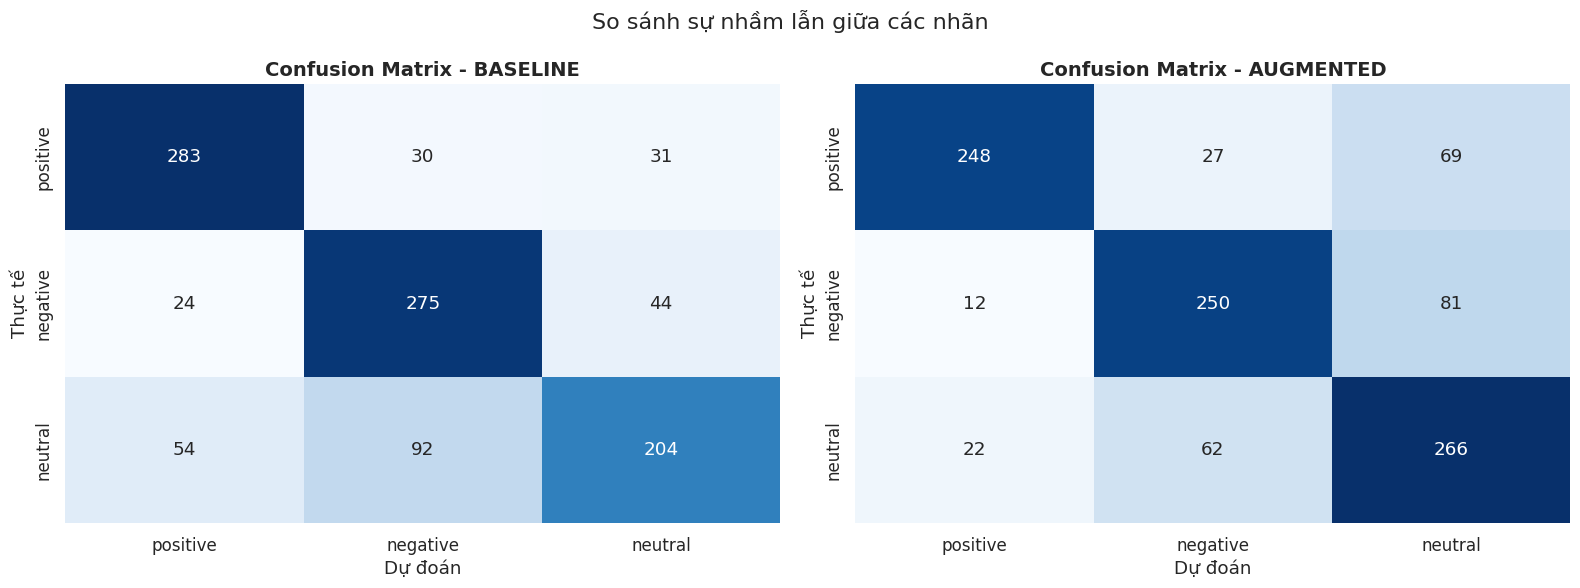

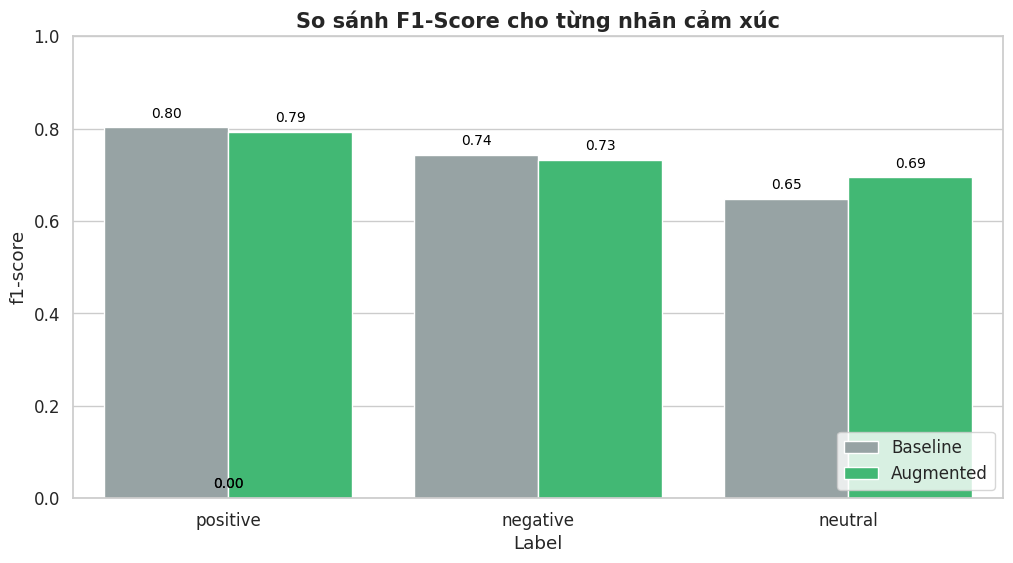


       BẢNG TỔNG HỢP HIỆU SUẤT (PERFORMANCE SUMMARY)        
| Metric          |   Baseline |   Augmented |
|:----------------|-----------:|------------:|
| Accuracy        |     0.7348 |      0.7367 |
| Macro F1        |     0.7316 |      0.74   |
| Macro Precision |     0.7359 |      0.7521 |
| Macro Recall    |     0.7358 |      0.7366 |

                  CHI TIẾT: MODEL BASELINE                  
              precision    recall  f1-score   support

    positive       0.78      0.82      0.80       344
    negative       0.69      0.80      0.74       343
     neutral       0.73      0.58      0.65       350

    accuracy                           0.73      1037
   macro avg       0.74      0.74      0.73      1037
weighted avg       0.74      0.73      0.73      1037


                 CHI TIẾT: MODEL AUGMENTED                  
              precision    recall  f1-score   support

    positive       0.88      0.72      0.79       344
    negative       0.74      0.73      0.7

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainer, Seq2SeqTrainingArguments, DataCollatorForSeq2Seq

# --- 1. CẤU HÌNH & LOAD MODEL ---
# Đường dẫn model (Đảm bảo bạn đã chạy bước train/lưu model trước đó)
model_baseline_path = f"{drive_path}/vit5_baseline_final"
model_aug_path = f"{drive_path}/vit5_augmented_final"

print("⏳ Đang tải các model để đánh giá...")

# Load lại model từ Drive
try:
    model_baseline_eval = AutoModelForSeq2SeqLM.from_pretrained(model_baseline_path)
    model_aug_eval = AutoModelForSeq2SeqLM.from_pretrained(model_aug_path)
except OSError:
    print(f"❌ Lỗi: Không tìm thấy model tại {drive_path}. Vui lòng kiểm tra lại đường dẫn hoặc chạy bước Train trước.")
    raise

# Tạo Trainer chỉ để predict (không cần training args phức tạp)
args_eval = Seq2SeqTrainingArguments(output_dir="./eval_temp", per_device_eval_batch_size=32, predict_with_generate=True, fp16=True, report_to="none")
data_collator = DataCollatorForSeq2Seq(tokenizer, padding=True)

trainer_baseline = Seq2SeqTrainer(model=model_baseline_eval, args=args_eval, tokenizer=tokenizer, data_collator=data_collator)
trainer_aug = Seq2SeqTrainer(model=model_aug_eval, args=args_eval, tokenizer=tokenizer, data_collator=data_collator)

# --- 2. HÀM DỰ ĐOÁN & XỬ LÝ KẾT QUẢ ---
def get_labels_and_preds(trainer, test_dataset):
    print(f"   ...Đang dự đoán trên tập test...")
    output = trainer.predict(test_dataset)

    # Decode kết quả từ token IDs sang text
    preds = tokenizer.batch_decode(output.predictions, skip_special_tokens=True)
    labels = tokenizer.batch_decode(output.label_ids, skip_special_tokens=True)

    # Chuẩn hóa text (bỏ khoảng trắng thừa, lowercase)
    preds = [p.strip().lower() for p in preds]
    labels = [l.strip().lower() for l in labels]

    # Xử lý trường hợp nhãn bị rỗng (hiếm gặp nhưng nên có)
    labels = [l if l else 'neutral' for l in labels]

    return labels, preds

print("\n🚀 Bắt đầu đánh giá Model BASELINE...")
y_true, y_pred_base = get_labels_and_preds(trainer_baseline, tokenized["test"])

print("\n🚀 Bắt đầu đánh giá Model AUGMENTED...")
_, y_pred_aug = get_labels_and_preds(trainer_aug, tokenized["test"])

# --- 3. TÍNH TOÁN METRICS CHI TIẾT ---
# Định nghĩa nhãn để đảm bảo thứ tự thống nhất
labels_list = ['positive', 'negative', 'neutral']

def get_metrics_df(y_true, y_pred, model_name):
    report = classification_report(y_true, y_pred, target_names=labels_list, labels=labels_list, output_dict=True)
    df = pd.DataFrame(report).transpose()
    df['Model'] = model_name
    return df

df_metrics_base = get_metrics_df(y_true, y_pred_base, 'Baseline')
df_metrics_aug = get_metrics_df(y_true, y_pred_aug, 'Augmented')

# --- 4. TRỰC QUAN HÓA (VISUALIZATION) ---
sns.set(style="whitegrid", font_scale=1.1)

# A. Confusion Matrix (So sánh 2 model)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

def plot_cm(y_true, y_pred, title, ax):
    cm = confusion_matrix(y_true, y_pred, labels=labels_list)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels_list, yticklabels=labels_list, ax=ax, cbar=False)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('Dự đoán')
    ax.set_ylabel('Thực tế')

plot_cm(y_true, y_pred_base, "Confusion Matrix - BASELINE", axes[0])
plot_cm(y_true, y_pred_aug, "Confusion Matrix - AUGMENTED", axes[1])
plt.suptitle("So sánh sự nhầm lẫn giữa các nhãn", fontsize=16)
plt.tight_layout()
plt.show()

# B. So sánh F1-Score từng lớp (Bar Chart)
# Gộp data để vẽ
df_concat = pd.concat([df_metrics_base.loc[labels_list], df_metrics_aug.loc[labels_list]]).reset_index().rename(columns={'index': 'Label'})

plt.figure(figsize=(12, 6))
sns.barplot(data=df_concat, x='Label', y='f1-score', hue='Model', palette=['#95a5a6', '#2ecc71'])
plt.title("So sánh F1-Score cho từng nhãn cảm xúc", fontsize=15, fontweight='bold')
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center', fontsize=10, color='black', xytext=(0, 10), textcoords='offset points')
plt.show()

# C. Bảng tổng hợp chỉ số quan trọng (Macro Avg & Accuracy)
summary_data = {
    'Metric': ['Accuracy', 'Macro F1', 'Macro Precision', 'Macro Recall'],
    'Baseline': [
        accuracy_score(y_true, y_pred_base),
        f1_score(y_true, y_pred_base, average='macro'),
        df_metrics_base.loc['macro avg', 'precision'],
        df_metrics_base.loc['macro avg', 'recall']
    ],
    'Augmented': [
        accuracy_score(y_true, y_pred_aug),
        f1_score(y_true, y_pred_aug, average='macro'),
        df_metrics_aug.loc['macro avg', 'precision'],
        df_metrics_aug.loc['macro avg', 'recall']
    ]
}
df_summary = pd.DataFrame(summary_data)

print("\n" + "="*60)
print("BẢNG TỔNG HỢP HIỆU SUẤT (PERFORMANCE SUMMARY)".center(60))
print("="*60)
print(df_summary.round(4).to_markdown(index=False))

# D. Classification Report chi tiết
print("\n" + "="*60)
print("CHI TIẾT: MODEL BASELINE".center(60))
print("="*60)
print(classification_report(y_true, y_pred_base, target_names=labels_list, labels=labels_list))

print("\n" + "="*60)
print("CHI TIẾT: MODEL AUGMENTED".center(60))
print("="*60)
print(classification_report(y_true, y_pred_aug, target_names=labels_list, labels=labels_list))

ĐÁNH GIÁ BẰNG LLM

In [ ]:
import pandas as pd

# 1. Lấy dữ liệu gốc của tập test (từ biến 'data' ở cell trước đó)
prepared_test_set = data['test']

inputs = prepared_test_set['input_text']
ground_truth = y_true

# 2. Lấy dự đoán từ 2 mô hình
preds_baseline_text = y_pred_base
preds_aug_text = y_pred_aug

# 3. Tạo DataFrame để so sánh (không cần decode lại)
df_analysis = pd.DataFrame({
    "Input": [text.replace("Phân loại cảm xúc: ", "") for text in inputs],  # Bỏ prefix cho gọn
    "Ground_Truth": ground_truth,
    "Baseline_Pred": preds_baseline_text,
    "Augmented_Pred": preds_aug_text
})

# 4. Thêm cột xem dự đoán ĐÚNG hay SAI
df_analysis['Baseline_Correct'] = (df_analysis['Ground_Truth'] == df_analysis['Baseline_Pred'])
df_analysis['Augmented_Correct'] = (df_analysis['Ground_Truth'] == df_analysis['Augmented_Pred'])

print("Bảng phân tích kết quả chi tiết đã sẵn sàng!")
df_analysis.head(10)

Bảng phân tích kết quả chi tiết đã sẵn sàng!


,Input,Ground_Truth,Baseline_Pred,Augmented_Pred,Baseline_Correct,Augmented_Correct
0,"Không nên mua chuột cua Logitech , vì dùng nó ...",positive,negative,neutral,False,False
1,Nói thiệt là mình thì thì chuột nào mình cũng ...,negative,negative,negative,True,True
2,Xai chuot so nhat bi double click .,neutral,negative,negative,False,False
3,Cơ bản là thiết kế ôm chuột chưa đã Như hiện g...,positive,positive,positive,True,True
4,Đang dùng mx1 . Cũng ngon nhưng chưa đầy năm m...,negative,positive,negative,False,True
5,mình chưa được đụng tới con đời 1 nữa,neutral,negative,neutral,False,True
6,"Chưa thấy đc điểm thuyết phục để mua , nhất là...",negative,negative,negative,True,True
7,Mình xài chuột mit sứ nhỏ cổng giá 25 k / con .,neutral,neutral,neutral,True,True
8,Đang dùng con TT Esport Level10M mà cầm sang c...,positive,positive,neutral,True,False
9,"Vừa sắm em M905 , thấy nói ngon nhưng mới xài ...",positive,positive,positive,True,True


In [ ]:
print("="*50)
print("TRƯỜNG HỢP 1: Synthetic Data GIÚP SỬA LỖI (Baseline Sai, Augmented Đúng)")
print("="*50)
case1 = df_analysis[
    (df_analysis['Baseline_Correct'] == False) &
    (df_analysis['Augmented_Correct'] == True)
]
print(case1.to_markdown(index=False))


print("\n" + "="*50)
print("TRƯỜNG HỢP 2: Synthetic Data GÂY LỖI (Baseline Đúng, Augmented Sai)")
print("="*50)
case2 = df_analysis[
    (df_analysis['Baseline_Correct'] == True) &
    (df_analysis['Augmented_Correct'] == False)
]
print(case2.to_markdown(index=False))


print("\n" + "="*50)
print("TRƯỜNG HỢP 3: CA KHÓ (Cả hai cùng Sai)")
print("="*50)
case3 = df_analysis[
    (df_analysis['Baseline_Correct'] == False) &
    (df_analysis['Augmented_Correct'] == False)
]
print(case3.to_markdown(index=False))

TRƯỜNG HỢP 1: Synthetic Data GIÚP SỬA LỖI (Baseline Sai, Augmented Đúng)
| Input                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

In [ ]:
# 1. Chuyển đổi DataFrames (case1, 2, 3) thành chuỗi Markdown
# Chúng ta chỉ lấy 15-20 ví dụ hàng đầu của mỗi trường hợp để tránh prompt quá dài
md_case1 = case1.head(20).to_markdown(index=False)
md_case2 = case2.head(20).to_markdown(index=False)
md_case3 = case3.head(20).to_markdown(index=False)

# 2. Xây dựng Master Prompt (Prompt chuẩn mà tôi đã viết)
master_prompt = f"""
**Bối cảnh (Context):**
Bạn là một trợ lý AI chuyên gia về Phân tích Ngôn ngữ (NLP). Tôi đang thực hiện một dự án và đã huấn luyện 2 mô hình Encoder-Decoder (ViT5) để phân loại cảm xúc tiếng Việt:
1. Mô hình `Baseline`: Chỉ train trên dữ liệu gốc.
2. Mô hình `Augmented`: Train trên dữ liệu gốc + 1500 mẫu synthetic (do bạn tạo ra).

Tôi đã chạy cả hai mô hình trên tập `test set`. Dưới đây là 3 bảng phân tích các trường hợp dự đoán sai lệch.

**Yêu cầu (Task):**
Dựa trên 3 bảng phân tích lỗi dưới đây, hãy giúp tôi thực hiện **Bước 4b (LLM-based Evaluation)**.

Vui lòng viết một phân tích chi tiết, có cấu trúc rõ ràng, trong đó bạn (với tư cách là LLM mạnh) "chấm điểm" và phân tích các mô hình dựa trên các tiêu chí sau:

1.  **Phân tích Trường hợp 1 (Synthetic Data GIÚP SỬA LỖI):**
    * Chọn 3-4 ví dụ tiêu biểu từ bảng này.
    * Phân tích **Relevance (Độ liên quan):** Tại sao mô hình `Baseline` dự đoán sai?
    * Phân tích **Reasoning (Lập luận):** Dữ liệu synthetic đã "dạy" cho mô hình `Augmented` điều gì khiến nó dự đoán đúng?

2.  **Phân tích Trường hợp 2 (Synthetic Data GÂY LỖI):**
    * Chọn 3-4 ví dụ tiêu biểu.
    * Phân tích **Relevance:** Tại sao mô hình `Baseline` dự đoán đúng?
    * Phân tích **Reasoning:** Dữ liệu synthetic đã "dạy hỏng" (gây bias) mô hình `Augmented` như thế nào khiến nó dự đoán sai?

3.  **Phân tích Trường hợp 3 (CA KHÓ - Cả hai cùng Sai):**
    * Chọn 2-3 ví dụ.
    * Phân tích tại sao đây là những ca khó (ví dụ: mỉa mai, mơ hồ)?

4.  **Kết luận (Bước 5: Thảo luận):**
    * Viết một đoạn tổng kết thảo luận về hiệu quả thực sự của 1500 mẫu synthetic data. Chúng đã cải thiện ở đâu và gây ra thiên kiến ở đâu?

**DỮ LIỆU ĐẦU VÀO:**

==================================================
TRƯỜNG HỢP 1: Synthetic Data GIÚP SỬA LỖI (Baseline Sai, Augmented Đúng)
==================================================
{md_case1}

==================================================
TRƯỜNG HỢP 2: Synthetic Data GÂY LỖI (Baseline Đúng, Augmented Sai)
==================================================
{md_case2}

==================================================
TRƯỜNG HỢP 3: CA KHÓ (Cả hai cùng Sai)
==================================================
{md_case3}
"""

# 3. Gọi API và in kết quả
print("\n--- Đang gửi yêu cầu đến Gemini để thực hiện Bước 4b ---")
print("Vui lòng chờ... việc này có thể mất vài giây đến một phút...")

try:
    # Cấu hình an toàn để tránh bị chặn
    generation_config = genai.types.GenerationConfig(
        temperature=0.7,
        top_p=1.0,
        top_k=32,
    )
    safety_settings = [
        { "category": "HARM_CATEGORY_HARASSMENT", "threshold": "BLOCK_NONE" },
        { "category": "HARM_CATEGORY_HATE_SPEECH", "threshold": "BLOCK_NONE" },
        { "category": "HARM_CATEGORY_SEXUALLY_EXPLICIT", "threshold": "BLOCK_NONE" },
        { "category": "HARM_CATEGORY_DANGEROUS_CONTENT", "threshold": "BLOCK_NONE" },
    ]

    response = model_gemini.generate_content(
        master_prompt,
        generation_config=generation_config,
        safety_settings=safety_settings
    )

    print("\n--- KẾT QUẢ ĐÁNH GIÁ TỪ LLM (GEMINI) ---")
    # In kết quả với Markdown để Colab hiển thị đẹp
    display(Markdown(response.text))

except Exception as e:
    print(f"\nLỖI KHI GỌI API: {e}")


--- Đang gửi yêu cầu đến Gemini để thực hiện Bước 4b ---
Vui lòng chờ... việc này có thể mất vài giây đến một phút...

--- KẾT QUẢ ĐÁNH GIÁ TỪ LLM (GEMINI) ---


Chắc chắn rồi. Với vai trò là một chuyên gia NLP, tôi sẽ tiến hành **Bước 4b: LLM-based Evaluation** để phân tích sâu về hiệu quả của dữ liệu synthetic dựa trên các bảng phân tích lỗi bạn đã cung cấp.

***

### **Phân Tích Đánh Giá Hiệu Quả Dữ Liệu Synthetic (LLM-based Evaluation)**

**Tổng quan:** Phân tích này nhằm mục đích đánh giá tác động của 1500 mẫu dữ liệu synthetic lên mô hình ViT5. Chúng ta sẽ xem xét các trường hợp mà dữ liệu này giúp mô hình hiểu sâu hơn về ngữ nghĩa (sửa lỗi của `Baseline`), các trường hợp nó gây ra thiên kiến (tạo ra lỗi mới), và các trường hợp phức tạp mà cả hai mô hình đều chưa xử lý được.

---

### **1. Phân tích Trường hợp 1: Synthetic Data GIÚP SỬA LỖI**

Trong các trường hợp này, mô hình `Augmented` đã thể hiện khả năng hiểu ngữ cảnh và sắc thái tinh tế hơn so với `Baseline`. Dữ liệu synthetic dường như đã "dạy" cho mô hình các mẫu câu phức tạp hơn.

**Ví dụ tiêu biểu:**

1.  **Input:** `Đang dùng mx1 . Cũng ngon nhưng chưa đầy năm mà đã 3 lần tháo ra thay 3 nút bấm rồi . May còn lột được từ máy khác mà bỏ vào !`
    *   **Ground_Truth:** `negative`
    *   **Baseline:** `positive` | **Augmented:** `negative`
    *   **Relevance (Tại sao Baseline sai?):** Mô hình `Baseline` đã bị "đánh lừa" bởi từ khóa tích cực "ngon" xuất hiện ở đầu câu. Nó đã không đủ khả năng nhận diện cấu trúc câu tương phản "A nhưng B", nơi mà vế B (`chưa đầy năm mà đã 3 lần... thay nút`) mới là ý chính và mang sắc thái tiêu cực, thể hiện sự thất vọng về độ bền của sản phẩm.
    *   **Reasoning (Augmented học được gì?):** Dữ liệu synthetic có thể đã bao gồm nhiều mẫu câu theo cấu trúc **"[Lời khen/Đặc điểm tốt] + nhưng/tuy nhiên + [Phàn nàn/Vấn đề]"**. Việc tiếp xúc với các mẫu này giúp mô hình `Augmented` học được rằng liên từ "nhưng" là một dấu hiệu mạnh mẽ của sự thay đổi sắc thái tình cảm và trọng số của vế sau thường quan trọng hơn.

2.  **Input:** `Android luôn luôn rẻ tiền . Hèn gì chất lượng cũng rẻ tiền theo .`
    *   **Ground_Truth:** `negative`
    *   **Baseline:** `positive` | **Augmented:** `negative`
    *   **Relevance (Tại sao Baseline sai?):** `Baseline` có thể đã liên kết từ "rẻ tiền" với một khía cạnh tích cực (giá cả phải chăng). Nó không hiểu được sắc thái mỉa mai, chê bai trong vế thứ hai "chất lượng cũng rẻ tiền theo", nơi "rẻ tiền" mang nghĩa là "kém chất lượng".
    *   **Reasoning (Augmented học được gì?):** Mô hình `Augmented` đã học được cách phân biệt ngữ nghĩa của từ dựa vào ngữ cảnh. Dữ liệu synthetic có thể đã chứa các ví dụ mà cùng một từ (như "rẻ tiền") được sử dụng với cả hai sắc thái tích cực và tiêu cực. Điều này giúp mô hình không còn phụ thuộc máy móc vào từ khóa mà phân tích cả câu để đưa ra kết luận.

3.  **Input:** `Điện thoại rẻ tiền của Samsung giờ nhìn còn đẹp hơn cả iphone .`
    *   **Ground_Truth:** `positive`
    *   **Baseline:** `negative` | **Augmented:** `positive`
    *   **Relevance (Tại sao Baseline sai?):** Trường hợp này ngược lại với ví dụ trên. `Baseline` thấy từ "rẻ tiền" và ngay lập tức phân loại là `negative` mà không xem xét vế so sánh "đẹp hơn cả iphone", vốn là ý chính và mang sắc thái tích cực.
    *   **Reasoning (Augmented học được gì?):** Mô hình `Augmented` đã học được cách nhận diện cấu trúc so sánh hơn ("đẹp hơn", "tốt hơn", v.v.) là một tín hiệu mạnh của cảm xúc. Nó hiểu rằng trọng tâm của câu này là lời khen về thiết kế, chứ không phải là sự chê bai về phân khúc giá. Dữ liệu synthetic có lẽ đã bổ sung các mẫu câu so sánh để làm rõ sắc thái này.

---

### **2. Phân tích Trường hợp 2: Synthetic Data GÂY LỖI**

Đây là những trường hợp cho thấy mặt trái của data augmentation. Dữ liệu synthetic, nếu không đủ đa dạng hoặc có thiên kiến, có thể "dạy hư" mô hình, khiến nó quá nhạy cảm với một số mẫu câu nhất định và mất đi sự chính xác ở những ca đơn giản.

**Ví dụ tiêu biểu:**

1.  **Input:** `Mình đang rất cần 1 con SSD siêu như này , nhưng giá trên rõ ràng ko đủ khả năng để mua rồi`
    *   **Ground_Truth:** `neutral`
    *   **Baseline:** `neutral` | **Augmented:** `negative`
    *   **Relevance (Tại sao Baseline đúng?):** `Baseline` đã phân tích đúng rằng đây là một câu trần thuật, nêu lên một nhu cầu ("rất cần") và một thực tế ("ko đủ khả năng"). Người nói không bày tỏ cảm xúc tiêu cực về sản phẩm, mà chỉ về hoàn cảnh của bản thân.
    *   **Reasoning (Augmented bị dạy hỏng thế nào?):** Mô hình `Augmented` có thể đã học một quy tắc quá cứng nhắc từ dữ liệu synthetic: **"cụm từ chỉ sự không thể/thất bại (ví dụ: 'không đủ', 'không thể', 'không làm được') => tiêu cực"**. Nó đã liên kết việc "không đủ khả năng mua" với cảm xúc tiêu cực về sản phẩm, một sự suy diễn sai lầm. Thiên kiến này khiến mô hình nhầm lẫn giữa hoàn cảnh của người nói và đánh giá của họ về sản phẩm.

2.  **Input:** `Sao trông dầy thế nhỉ`
    *   **Ground_Truth:** `negative`
    *   **Baseline:** `negative` | **Augmented:** `neutral`
    *   **Relevance (Tại sao Baseline đúng?):** `Baseline` nhận diện đúng rằng câu hỏi tu từ này là một lời chê bai về thiết kế (dày = không đẹp, thô). Đây là một cách diễn đạt phổ biến trong tiếng Việt.
    *   **Reasoning (Augmented bị dạy hỏng thế nào?):** Dữ liệu synthetic có thể đã chứa nhiều câu hỏi thuần túy mang tính `neutral` (ví dụ: "Sản phẩm này có màu gì?", "Giá bao nhiêu?"). Điều này có thể đã tạo ra một thiên kiến khiến `Augmented` có xu hướng phân loại các câu hỏi là `neutral`, bỏ qua sắc thái ngầm định (chê bai, khen ngợi) trong các câu hỏi tu từ. Nó trở nên quá "thận trọng".

3.  **Input:** `Nếu vẫn thế này thì R.I.P Apple . Đây là cơ hội cho Samsung có những bước ngoặt lớn`
    *   **Ground_Truth:** `negative`
    *   **Baseline:** `negative` | **Augmented:** `positive`
    *   **Relevance (Tại sao Baseline đúng?):** `Baseline` đã nắm bắt được tín hiệu tiêu cực rất mạnh từ "R.I.P Apple" và xác định đúng sắc thái của cả câu.
    *   **Reasoning (Augmented bị dạy hỏng thế nào?):** Mô hình `Augmented` đã bị nhiễu bởi các từ khóa tích cực ở vế sau: "cơ hội", "bước ngoặt lớn". Dữ liệu synthetic có thể đã củng cố quá mức mối liên hệ giữa các từ này và cảm xúc tích cực, khiến mô hình bỏ qua ngữ cảnh tiêu cực rõ ràng ở vế đầu. Đây là một trường hợp "overfitting" vào các từ khóa tích cực.

---

### **3. Phân tích Trường hợp 3: CA KHÓ (Cả hai cùng Sai)**

Đây là những "bài toán" thực sự thách thức cho các mô hình NLP hiện tại, đòi hỏi khả năng suy luận sâu, hiểu biết về văn hóa và các hình thái ngôn ngữ phức tạp như mỉa mai.

1.  **Input:** `Không nên mua chuột cua Logitech , vì dùng nó rất khó đổi cái mới . Mình nghe thằng bạn xúi mua con M325 cách đây 5 năm , dù có cơ số lần rơi rớt quăng quật mà đến giờ vẫn chưa hư . Giờ đang thèm em MX Anywhere 2 này mà chuột cũ chưa hư sao mua chuột mới !`
    *   **Ground_Truth:** `positive`
    *   **Lý do khó:** Đây là một trường hợp **mỉa mai kinh điển (sarcasm)** và **nói ngược**. Câu mở đầu bằng một mệnh đề phủ định mạnh ("Không nên mua"), nhưng toàn bộ phần giải thích sau đó lại là những lời khen ngợi tột bậc về độ bền của sản phẩm ("5 năm vẫn chưa hư"). Cả hai mô hình đều chỉ xử lý được lớp nghĩa bề mặt (surface-level meaning) của câu chữ mà không thể suy luận ra ý định thực sự của người viết.

2.  **Input:** `Rất đẹp , nhưng phù hợp với đeo cổ chân người Việt hơn .`
    *   **Ground_Truth:** `negative`
    *   **Lý do khó:** Đây là một lời **chê bai trá hình dưới dạng lời khen**. Vế đầu "Rất đẹp" là một tín hiệu tích cực giả. Vế sau "phù hợp với đeo cổ chân" là một cách nói ẩn dụ, mang tính miệt thị, ám chỉ sản phẩm quá to, thô kệch hoặc lòe loẹt. Để hiểu được câu này, mô hình cần có "world knowledge" và hiểu biết văn hóa về việc đeo lắc chân, điều mà dữ liệu huấn luyện thông thường không thể cung cấp.

3.  **Input:** `Xai chuot so nhat bi double click .`
    *   **Ground_Truth:** `neutral`
    *   **Lý do khó:** Câu này bị **mơ hồ về ngữ cảnh (ambiguity)**. Nó có thể được hiểu theo hai cách:
        a. Một lời phàn nàn rằng con chuột *này* đang bị lỗi double click (`negative`).
        b. Một phát biểu chung chung rằng lỗi double click là điều đáng sợ nhất khi dùng chuột (`neutral`).
    Cả hai mô hình đều diễn giải theo hướng (a), có lẽ vì "sợ nhất" và "double click" (một thuật ngữ chỉ lỗi) là các tín hiệu tiêu cực mạnh. Việc xác định đúng ý định của người viết đòi hỏi phải có các câu xung quanh để làm rõ ngữ cảnh.

---

### **4. Kết luận (Bước 5: Thảo luận)**

Việc bổ sung 1500 mẫu dữ liệu synthetic đã mang lại những kết quả hai mặt, cho thấy data augmentation là một con dao hai lưỡi cần được sử dụng một cách cẩn trọng.

*   **Mặt tích cực (Cải thiện ở đâu?):**
    *   Dữ liệu synthetic rõ ràng đã giúp mô hình `Augmented` **vượt qua việc phụ thuộc vào từ khóa đơn lẻ**. Nó đã cải thiện đáng kể khả năng hiểu các cấu trúc câu phức tạp, đặc biệt là các câu có **cảm xúc hỗn hợp (mixed sentiment)** hoặc các câu có **liên từ tương phản** ("nhưng", "tuy nhiên").
    *   Mô hình đã học được cách **xem xét ngữ cảnh** để xác định ý nghĩa thực sự của một từ, như trong trường hợp từ "rẻ tiền" có thể mang cả nghĩa tích cực và tiêu cực.

*   **Mặt tiêu cực (Gây ra thiên kiến ở đâu?):**
    *   Mặt khác, dữ liệu synthetic dường như đã tạo ra các **quy tắc suy diễn quá cứng nhắc (overfitting on patterns)**. Mô hình `Augmented` bắt đầu nhầm lẫn giữa hoàn cảnh của người dùng và đánh giá sản phẩm (ví dụ "không đủ tiền mua").
    *   Nó cũng phát triển thiên kiến với một số loại câu nhất định, chẳng hạn như có xu hướng coi các câu hỏi là `neutral` hoặc quá nhạy cảm với các từ khóa tích cực ("cơ hội", "bước ngoặt") mà bỏ qua ngữ cảnh tiêu cực bao trùm.

**Kết luận cuối cùng:** 1500 mẫu synthetic đã thành công trong việc nâng cao "trí thông minh ngôn ngữ" của mô hình, giúp nó giải quyết các ca phức tạp mà `Baseline` thất bại. Tuy nhiên, quá trình này cũng vô tình đưa vào các "điểm mù" và thiên kiến mới. Điều này cho thấy rằng chất lượng và sự đa dạng của dữ liệu synthetic quan trọng hơn số lượng. Để cải thiện hơn nữa, các bước tiếp theo nên tập trung vào việc tạo ra dữ liệu synthetic có chủ đích để giải quyết các ca khó (như mỉa mai, ẩn dụ) và đồng thời kiểm tra chéo để đảm bảo không tạo ra các thiên kiến không mong muốn.